In [2]:
from pathlib import Path
import pickle

import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
from lightfm import LightFM
from scipy import sparse
from tqdm.auto import tqdm

from metric import apk, mapk
from utils import plot_images


In [3]:
ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(exist_ok=True)

In [4]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [5]:
# class CFG:
#     model_type = 'LightGBM'
#     num_popular_items = 12
#     train_weeks = 1
#     repurchase_weeks = 12345
#     repurchase_num_items = 100
#     item2item_weeks = 12345
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_weeks = 1


# BEST
class CFG:
    model_type = 'CatBoost'
    num_popular_items = 12
    num_segment_wise_popular_items = 12
    train_weeks = 3
    repurchase_weeks = 123456
    repurchase_num_items = 123456
    item2item_weeks = 123456
    item2item_num_items = 24
    cooc_weeks = 12
    cooc_threshold = 50
    dynamic_feature_weeks = 8
    volume_feature_weeks = 1

In [6]:
def train_lfm(
        transactions: pd.DataFrame,
        n_user: int,
        n_item: int,
        week_start: int,
        week_num: int,
):
    week_end = week_start + week_num
    a = transactions.query("@week_start <= week < @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)

    a_train = sparse.lil_matrix((n_user, n_item))
    a_train[a['user'], a['item']] = 1

    lightfm_params = {
        'no_components': 16,
        'learning_schedule': 'adadelta',
        'loss': 'bpr',
        'learning_rate': 0.005,
    }

    model = LightFM(**lightfm_params)
    model.fit(a_train, epochs=100, num_threads=psutil.cpu_count(logical=False), verbose=True)
    with open(ARTIFACTS_DIR / f"lfm_{dataset}_{week_start}.pkl", 'wb') as f:
        pickle.dump(model, f)

# train_lfm(transactions, len(users), len(items), CFG.train_weeks+1, CFG.repurchase_weeks)  # for train/valid
# train_lfm(transactions, len(users), len(items), CFG.train_weeks, CFG.repurchase_weeks)  # for train/test

In [7]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"week: {week}")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            max_items_per_user: int) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_num: int) -> pd.DataFrame:
        week_end = week_start + week_num
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:CFG.num_popular_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(CFG.num_popular_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_segment_wise_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            users: pd.DataFrame,
            week_start: int,
            week_num: int) -> pd.DataFrame:
        week_end = week_start + week_num
        users = users.copy()
        users['segment'] = users['age'] // 5
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(users[['user', 'segment']], on='user')
        tmp = tr.groupby(['segment', 'item']).size().reset_index(name='cnt_in_segment')
        tmp['rank_in_segment'] = tmp.groupby('segment')['cnt_in_segment'].rank(ascending=False, method='dense')
        tmp = tmp.query('rank_in_segment <= @CFG.num_popular_items')

        candidates = (pd.DataFrame({'user': target_users})
                      .merge(users[['user', 'segment']], on='user')
                      .merge(tmp[['item', 'segment', 'rank_in_segment']], on=['segment'])
                      .drop('segment',axis=1))

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_num: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        week_end = week_start + week_num
        # TODO: 元々バグってたので閾値とか要検討
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("cnt > @CFG.cooc_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, CFG.repurchase_weeks, CFG.repurchase_num_items)
    candidates_popular = create_candidates_popular('pop', transactions, target_users, week, 1)
    candidates_segment_wise_popular = create_candidates_segment_wise_popular('pop_segment_wise', transactions, target_users, users, week, 1)

    candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.repurchase_weeks, CFG.item2item_num_items)
    candidates_cooc = create_candidates_cooc('cooc', transactions, week, CFG.cooc_weeks, candidates_item2item)
    candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_item2item)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)

    # candidates_segment_wise_popular = drop_common_user_item(candidates_segment_wise_popular, candidates_popular)
    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        # candidates_popular,
        candidates_segment_wise_popular,
        candidates_cooc,
        candidates_same_product_code,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [8]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

week: 1
volume: 13309442
duplicates: 1.0561620872859734
            strategy   volume     ratio
0  same_product_code  6876142  0.516636
1         repurchase  3446562  0.258956
2   pop_segment_wise  1782997  0.133965
3               cooc  1203741  0.090443
week: 2
volume: 14443637
duplicates: 1.0612252110362261
            strategy   volume     ratio
0  same_product_code  7228749  0.500480
1         repurchase  3637145  0.251816
2   pop_segment_wise  2159706  0.149526
3               cooc  1418037  0.098177
week: 3
volume: 15005536
duplicates: 1.065666956918268
            strategy   volume     ratio
0  same_product_code  7678831  0.511733
1         repurchase  3742824  0.249430
2   pop_segment_wise  1993196  0.132831
3               cooc  1590685  0.106007
week: 4
volume: 15850940
duplicates: 1.0696515801427215
            strategy   volume     ratio
0  same_product_code  8177755  0.515916
1         repurchase  3915353  0.247011
2   pop_segment_wise  1960254  0.123668
3               c

In [9]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"week: {week}")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [10]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


week: 0
Recall: 0.11363976643210061
            strategy       y   volume    recall  hit_ratio
0         repurchase  8437.0  3446562  0.039475   0.002448
1  same_product_code  7888.0  6876142  0.036907   0.001147
2   pop_segment_wise  7295.0  1782997  0.034132   0.004091
3               cooc  5096.0  1203741  0.023843   0.004233
week: 1
Recall: 0.11067526655258655
            strategy       y   volume    recall  hit_ratio
0         repurchase  8955.0  3637145  0.039292   0.002462
1  same_product_code  8554.0  7228749  0.037532   0.001183
2   pop_segment_wise  7430.0  2159706  0.032601   0.003440
3               cooc  5210.0  1418037  0.022860   0.003674
week: 2
Recall: 0.1104782546603157
            strategy       y   volume    recall  hit_ratio
0         repurchase  9195.0  3742824  0.038622   0.002457
1  same_product_code  8829.0  7678831  0.037085   0.001150
2   pop_segment_wise  7998.0  1993196  0.033595   0.004013
3               cooc  5376.0  1590685  0.022581   0.003380
week: 3


In [11]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 13309442 -> 4139609
drop trivial queries: 14443637 -> 4553081
drop trivial queries: 15005536 -> 4668092
drop trivial queries: 15850940 -> 4660126


In [12]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"week: {week}")
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
    tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    week_end = week + CFG.volume_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
    df = df.merge(tmp, on='item', how='left')

    # # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
    # tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
    # df = df.merge(tmp, on='user', how='left')

    # # user volume features
    # week_end = week + CFG.volume_feature_weeks
    # tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
    # df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
    tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()

    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    week_end = week + CFG.volume_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')

    # lfm features
    lfm_path = ARTIFACTS_DIR / f"lfm_{dataset}_{pretrain_week}.pkl"

    with open(lfm_path, 'rb') as f:
        lfm = pickle.load(f)
    no_components = lfm.get_params()['no_components']

    # df['lfm'] = lfm.predict(df['user'].values, df['item'].values, num_threads=psutil.cpu_count(logical=False))

    user_reps = np.hstack([lfm.user_embeddings, lfm.user_biases.reshape((len(users), 1))])
    user_reps = pd.DataFrame(user_reps, columns=[f'user_rep_{i}' for i in range(no_components+1)])
    user_reps = pd.concat([pd.DataFrame({'user': range(len(users))}), user_reps], axis=1)
    df = df.merge(user_reps, on='user')

    assert len(df) == n_original
    return df


valid_all = attach_features(transactions, users, items, valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

week: 1
week: 1
week: 2
week: 3
week: 4


In [13]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [14]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [15]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'rank_in_segment', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_item_day_min', 'user_item_volume', 'user_rep_0', 'user_rep_1', 'user_rep_2', 'user_rep_3', 'user_rep_4', 'user_rep_5', 'user_rep_6', 'user_r

In [16]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [17]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1878592	best: 0.1878592 (0)	total: 4.44s	remaining: 1h 13m 57s
1:	test: 0.2591492	best: 0.2591492 (1)	total: 8.25s	remaining: 1h 8m 35s
2:	test: 0.2636301	best: 0.2636301 (2)	total: 12s	remaining: 1h 6m 40s
3:	test: 0.2622145	best: 0.2636301 (2)	total: 15.9s	remaining: 1h 6m 1s
4:	test: 0.2629523	best: 0.2636301 (2)	total: 19.7s	remaining: 1h 5m 20s
5:	test: 0.2670004	best: 0.2670004 (5)	total: 23.5s	remaining: 1h 4m 54s
6:	test: 0.2679431	best: 0.2679431 (6)	total: 27.3s	remaining: 1h 4m 37s
7:	test: 0.2735143	best: 0.2735143 (7)	total: 31.2s	remaining: 1h 4m 26s
8:	test: 0.2736261	best: 0.2736261 (8)	total: 35s	remaining: 1h 4m 18s
9:	test: 0.2736968	best: 0.2736968 (9)	total: 38.8s	remaining: 1h 4m 3s
10:	test: 0.2909033	best: 0.2909033 (10)	total: 42.6s	remaining: 1h 3m 54s
11:	test: 0.2942591	best: 0.2942591 (11)	total: 46.4s	remaining: 1h 3m 43s
12:	test: 0.2973262	best: 0.2973262 (12)	total: 50.2s	remaining: 1h 3m 33s
13:	test: 0.3045500	best: 0.3045500 (13)	total: 54

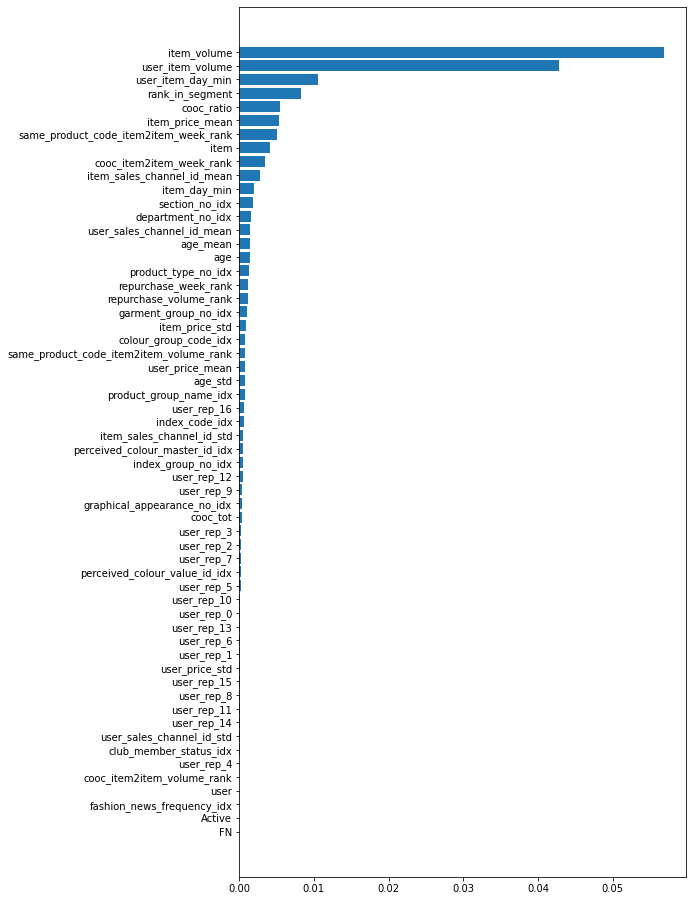

In [18]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_pool = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
    }
    model = catboost.CatBoost(params)
    model.fit(train_pool, eval_set=valid_pool)

    feature_importance = model.get_feature_importance(train_pool)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [19]:
valid_all['pred'] = model.predict(valid_all[feature_columns])

In [20]:
pred = valid_all.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

In [21]:
gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle('output/merged.pkl')
valid_all.to_pickle('output/valid_all.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.03300245064636314


In [ ]:
assert False

submission

In [ ]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

In [ ]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_pool = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_pool)

    feature_importance = model.get_feature_importance(train_pool)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [ ]:
all_users = users['user'].values
all_users

In [ ]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

In [ ]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [ ]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)